In [79]:
#Bộ dữ liệu đang được sử dụng cho Dự báo lưu lượng truy cập trang web.
#được thu thập từ dữ liệu lưu lượng truy cập hàng ngày của thecleverprogrammer.com. 
#Nó chứa dữ liệu về dữ liệu lưu lượng truy cập hàng ngày từ tháng 6 năm 2021 đến tháng 6 năm 2022.

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

data = pd.read_csv("Thecleverprogrammer.csv")
print(data.head())

         Date  Views
0  01/06/2021   7831
1  02/06/2021   7798
2  03/06/2021   7401
3  04/06/2021   7054
4  05/06/2021   7973


In [80]:
#Tập dữ liệu chứa hai cột, ngày và lưu lượng truy cập. 
#Chuyển đổi cột Ngày thành kiểu dữ liệu Ngày giờ.
data["Date"] = pd.to_datetime(data["Date"], 
                              format="%d/%m/%Y")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    391 non-null    datetime64[ns]
 1   Views   391 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.2 KB
None


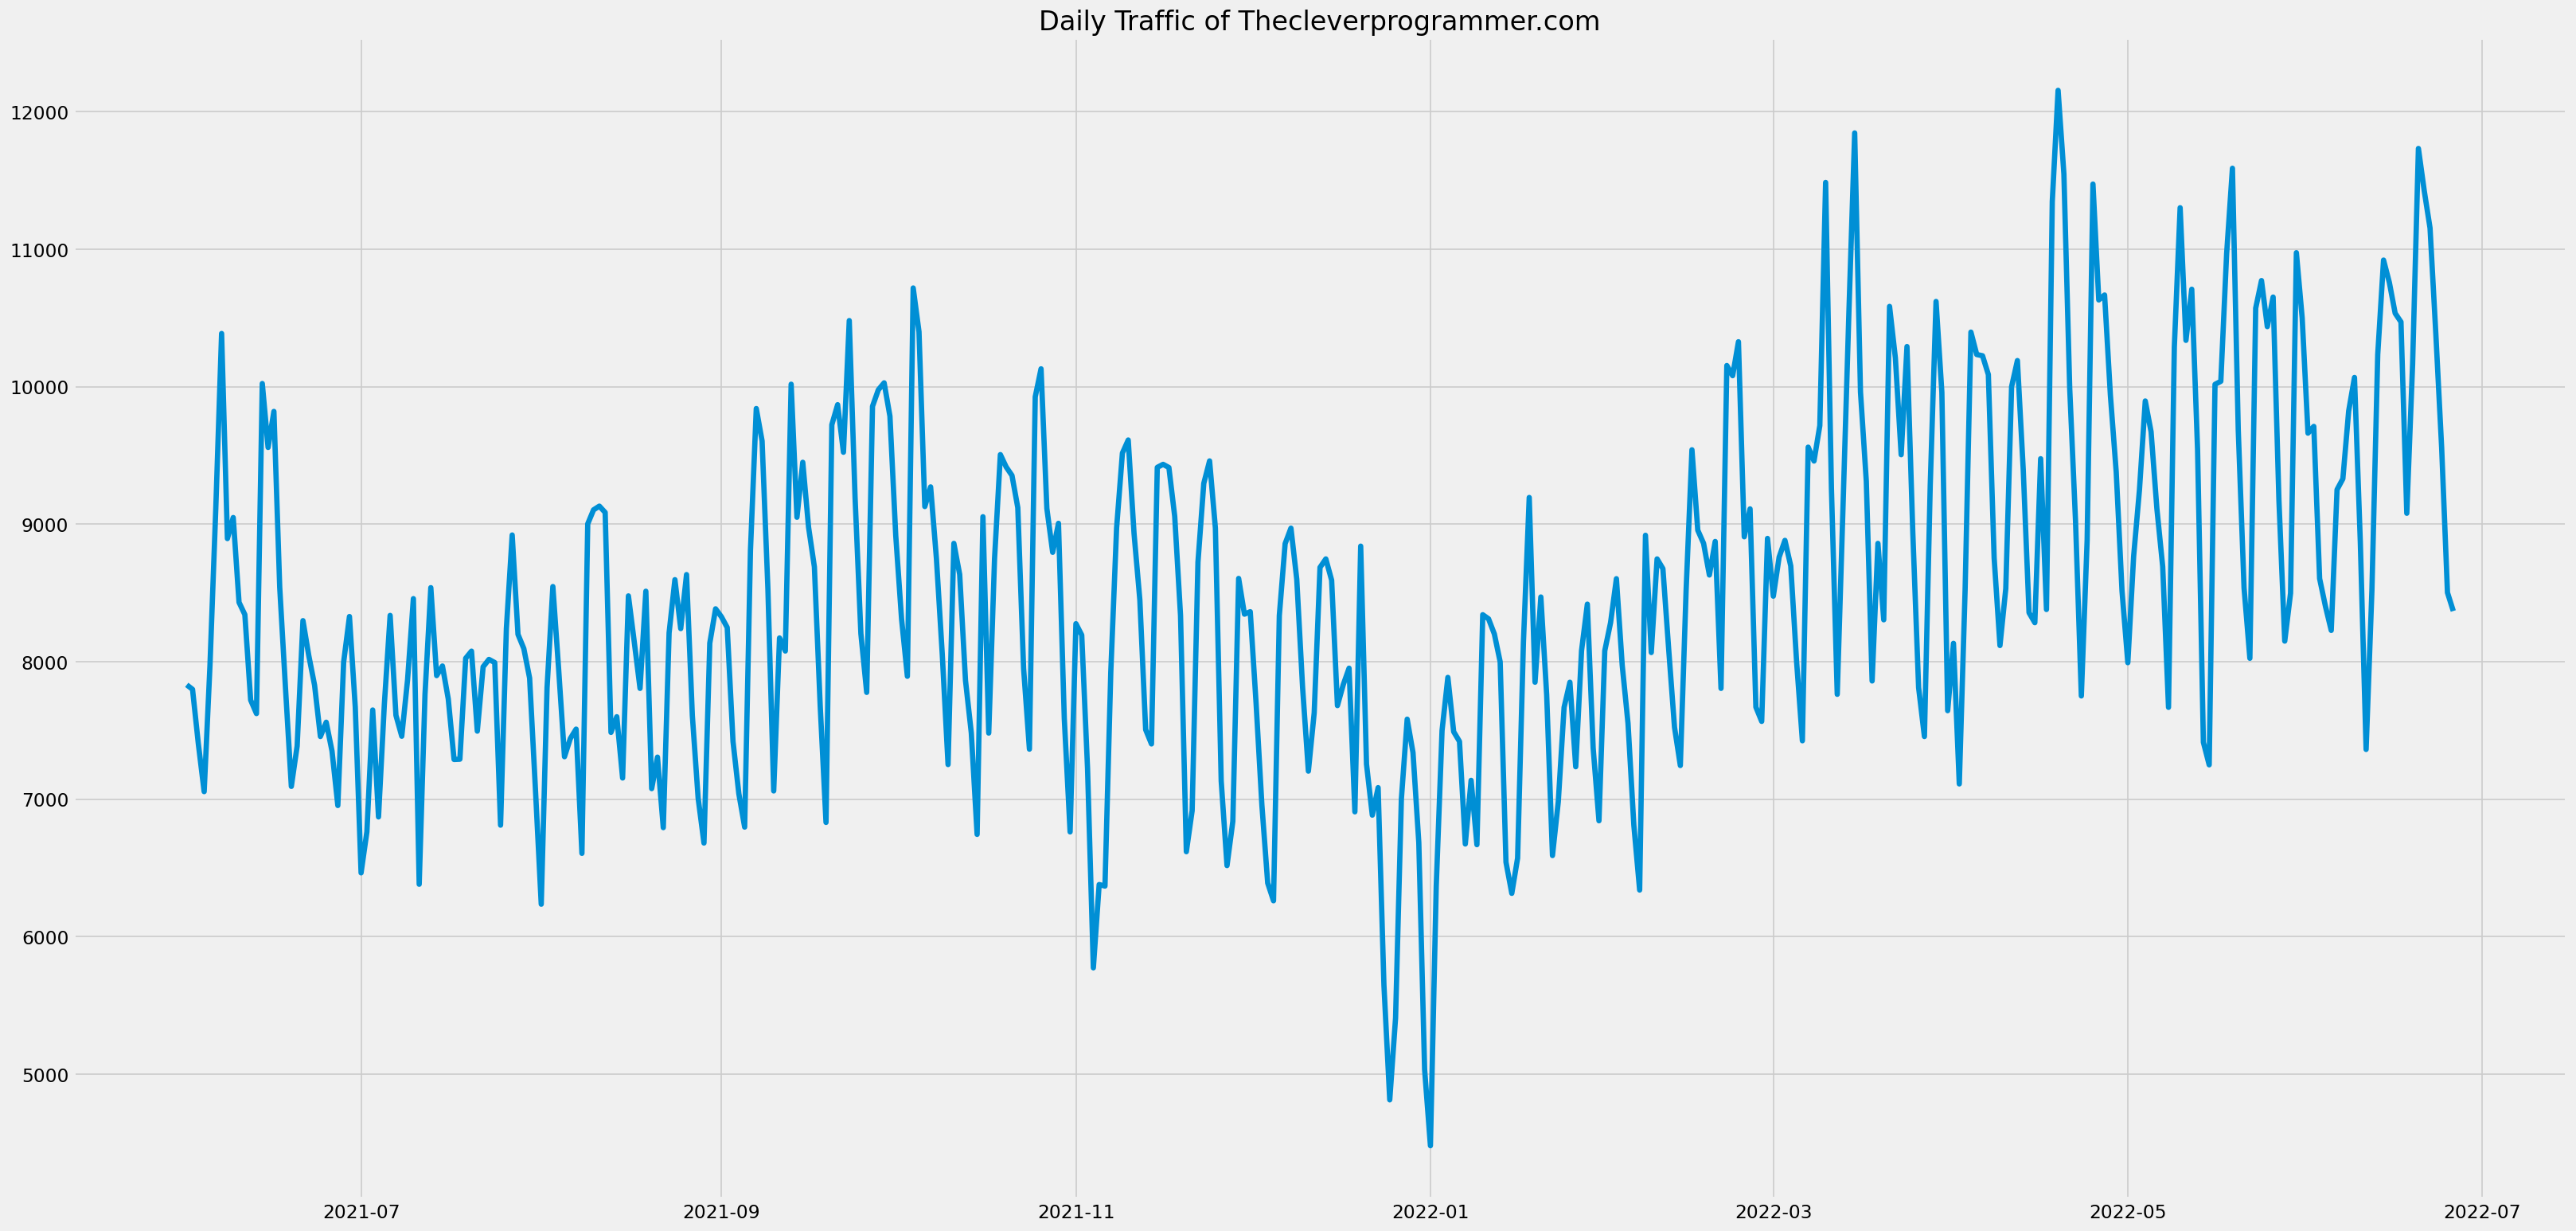

In [81]:
#Cột Ngày giờ ban đầu là một đối tượng, vì vậy đã chuyển đổi nó thành cột Ngày giờ.
#Xuất ra lưu lượng truy cập hàng ngày của trang web:

plt.style.use('fivethirtyeight')

#Kích thước biểu đồ
plt.figure(figsize=(30, 15))

plt.plot(data["Date"], data["Views"]) ##Cột dọc là số lượng truy cập, cột ngang là khoảng thời gian từ 06/2021 đến 06/2022

#Tiêu đề
plt.title("Daily Traffic of Thecleverprogrammer.com")

#Xuất ra biểu đồ
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

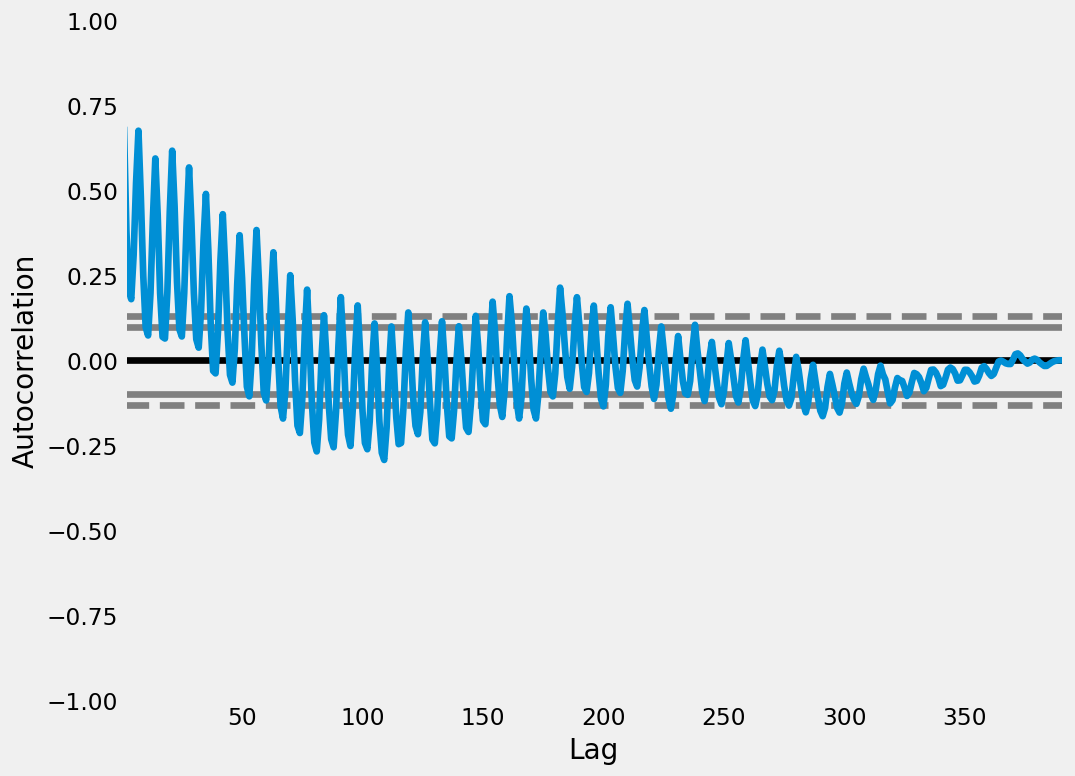

In [82]:
# Sử dụng mô hình ARIMA theo mùa (SARIMA) để dự báo lưu lượng truy cập trên trang web. 
# Trước khi sử dụng mô hình SARIMA, cần tìm các giá trị p, d và q.
# Vì dữ liệu không cố định nên giá trị của d là 1. 
# Để tìm giá trị của p và q, ta sử dụng biểu đồ tự tương quan và tự tương quan một phần:

pd.plotting.autocorrelation_plot(data["Views"])

<Figure size 1080x840 with 0 Axes>

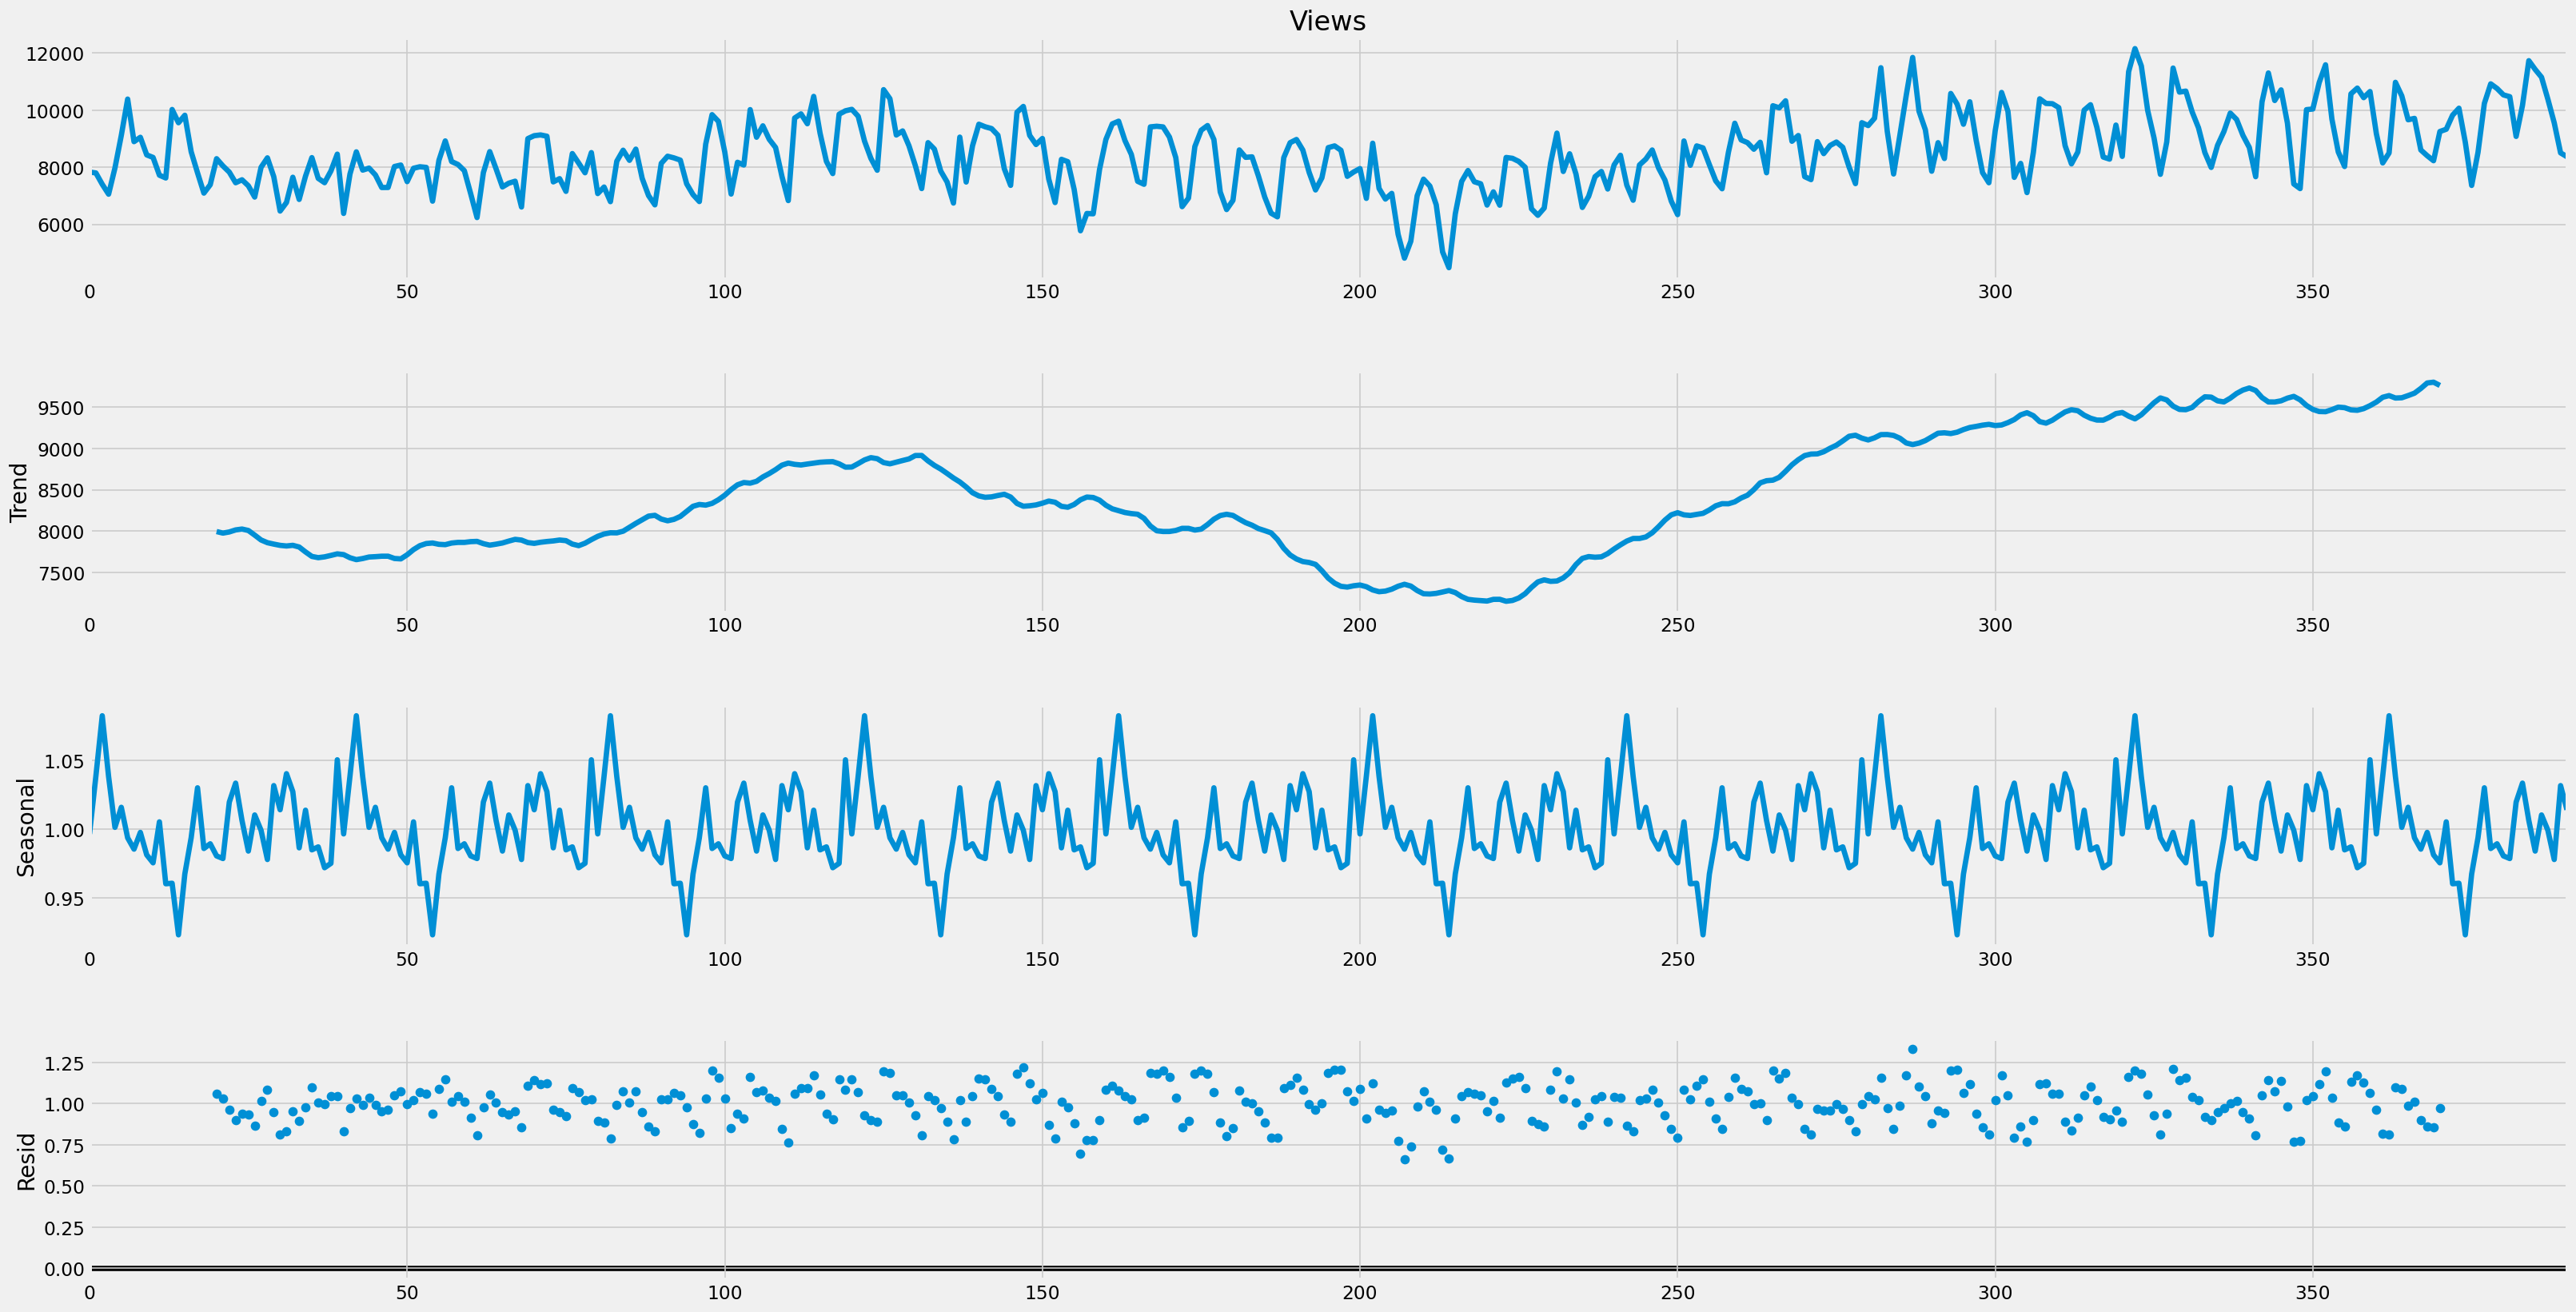

In [83]:
# Dữ liệu lưu lượng truy cập trang web của chúng tôi là theo mùa
# Vì lưu lượng truy cập trên trang web tăng vào các ngày trong tuần 
# và giảm vào các ngày cuối tuần. 
# Cần biết liệu tập dữ liệu có theo mùa hay không 
# trong khi giải quyết vấn đề về Dự báo chuỗi thời gian

result = seasonal_decompose(data["Views"], 
                            model='multiplicative', 
                            period = 40)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(30, 15)

In [84]:
# Augmented Dickey-Fuller test 
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['Views'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.788642
p-value: 0.386115
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


<AxesSubplot:>

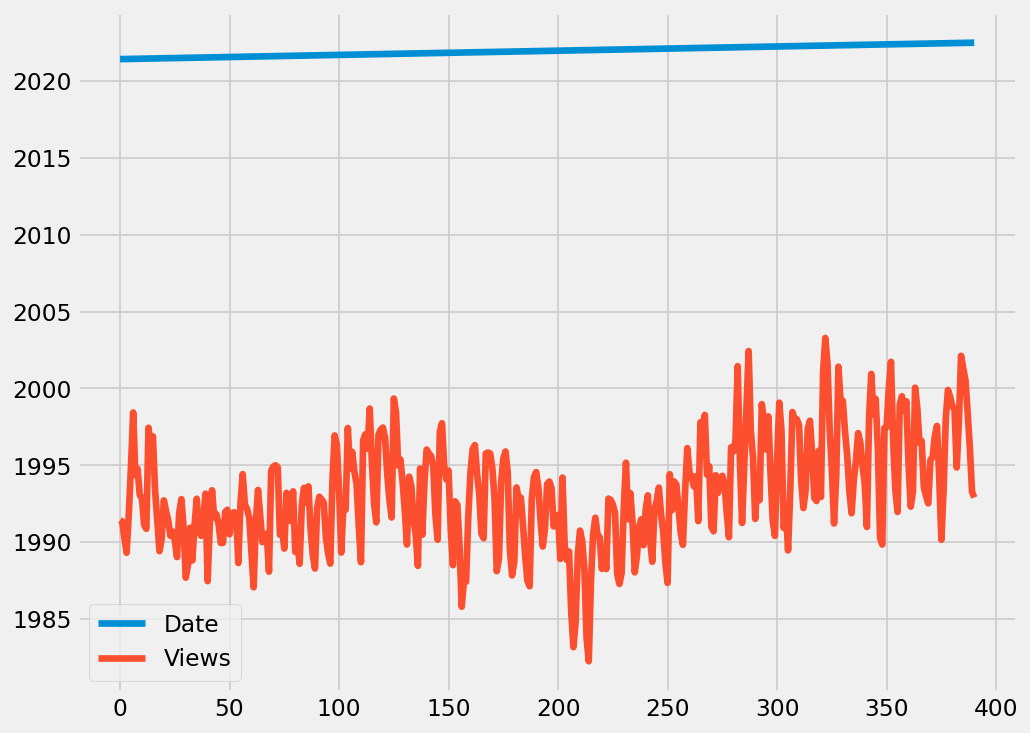

In [85]:
# Ở đây chúng ta có thể thấy rằng giá trị p lớn hơn 0,05
# điều này có nghĩa là giả thuyết rỗng của chúng ta sẽ bị bác bỏ 
# Và chúng ta sẽ coi chuỗi này là không cố định
# Tạo một biểu đồ dữ liệu này
data.plot()

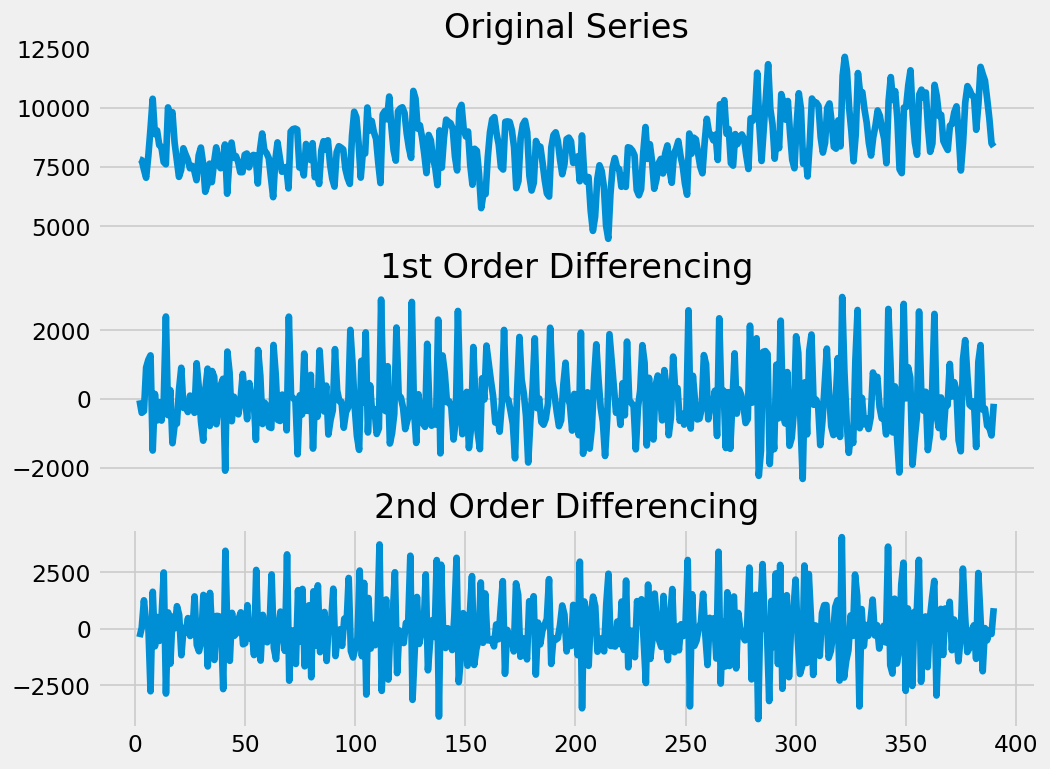

In [86]:
# Không có phương pháp nào có thể cho chúng ta biết giá trị của d bao nhiêu sẽ là tối ưu. 
# Tuy nhiên, giá trị của sự khác biệt có thể tối ưu cho đến 2
# vì vậy chúng ta sẽ thử chuỗi thời gian của mình cho cả hai. 
# Pandas cung cấp tùy chọn khác biệt này.

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(data.Views); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)

# 1st Differencing
ax2.plot(data.Views.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)

# 2nd Differencing
ax3.plot(data.Views.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

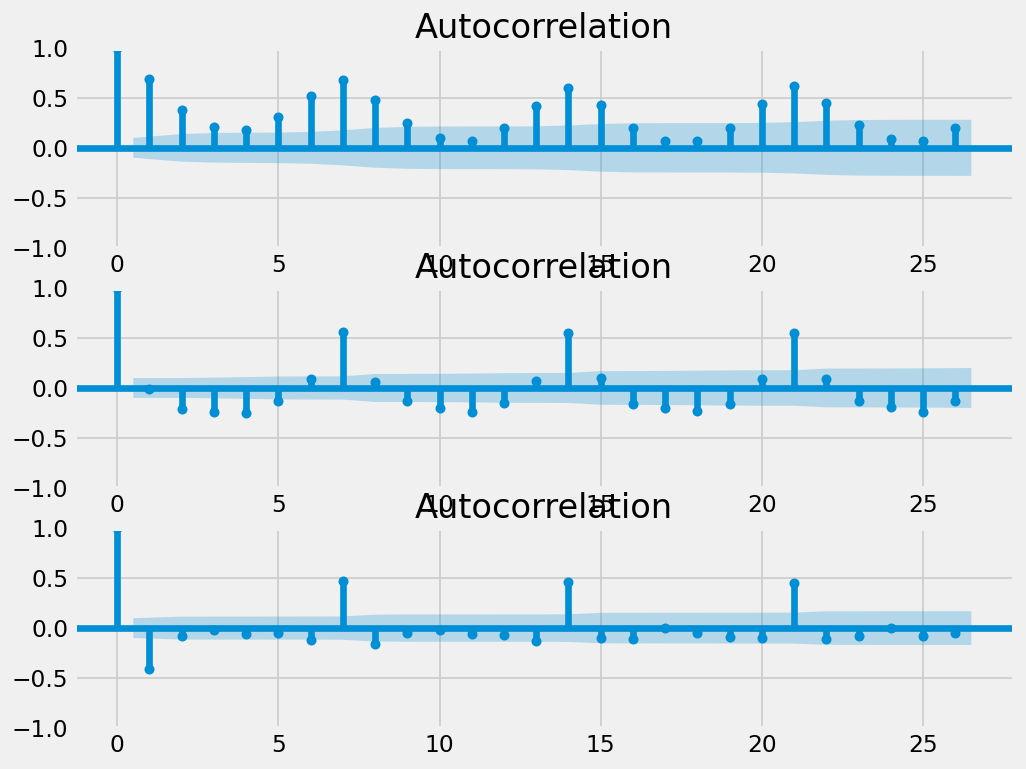

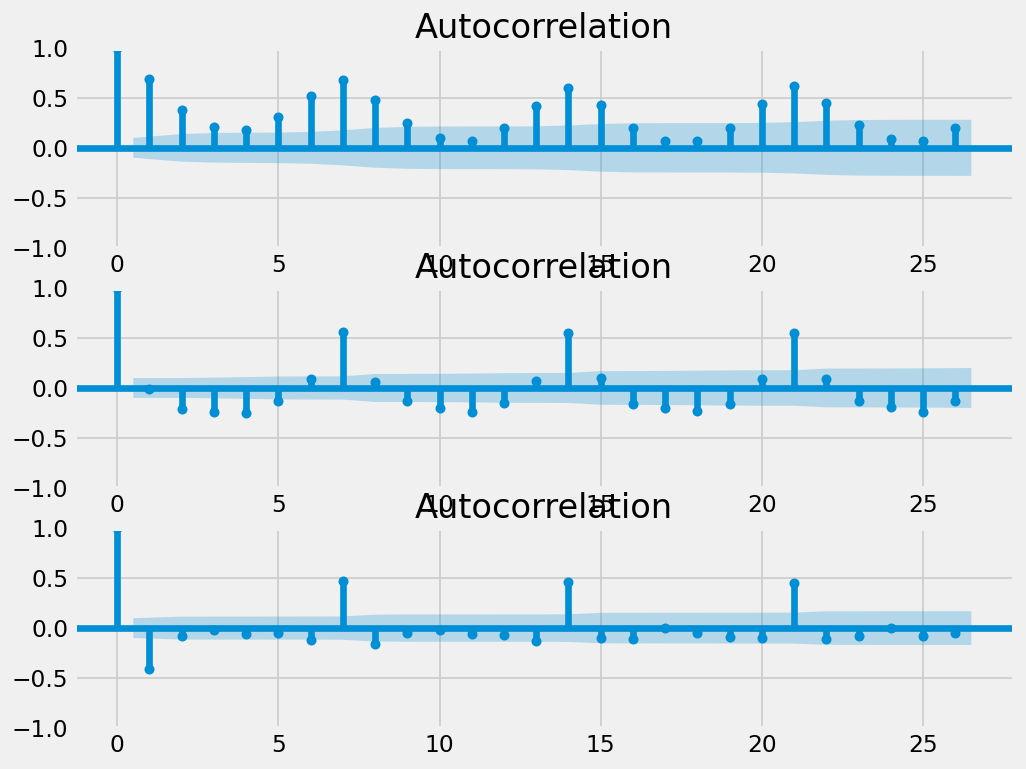

In [87]:
# Ở trên chúng ta có thể thấy chuỗi thời gian đã dừng
# Một điều đáng chú ý ở đây là trong sự khác biệt bậc nhất, 
# ta có ít sự nhiễu loạn hơn trong dữ liệu sau bậc 1, sự nhiễu loạn tăng lên.
# Vì vậy, ta có thể chọn chênh lệch thứ tự đầu tiên cho mô hình của mình.
# Chúng ta cũng có thể xác minh điều này bằng cách sử dụng biểu đồ tự tương quan.

from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(data.Views, ax=ax1)
plot_acf(data.Views.diff().dropna(), ax=ax2)
plot_acf(data.Views.diff().diff().dropna(), ax=ax3)

In [88]:
# Ở đây chúng ta có thể thấy rằng trong sai khác bậc hai, 
# độ trễ tức thời đã chuyển sang mặt tiêu cực, 
# thể hiện rằng ở bậc hai, chuỗi đã vượt qua sai khác.

In [89]:
# Trong phần trên, chúng ta đã xác định được giá trị tối ưu của d. 
# Bây giờ trong phần này, chúng ta sẽ tìm giá trị tối ưu của p 
# là số lượng các số hạng tự hồi quy của chúng ta. 
# Chúng ta có thể tìm thấy giá trị này bằng cách kiểm tra biểu đồ PACF. 

# Biểu đồ hàm tự tương quan từng phần có thể được sử dụng 
# để vẽ mối tương quan giữa chuỗi thời gian
# và độ trễ của nó trong khi đóng góp từ độ trễ trung gian có thể được bỏ qua. 
# Biểu đồ này sẽ cho chúng ta biết về độ trễ không cần thiết trong phần tự hồi quy.

# Mối tương quan đáng kể trong chuỗi thời gian cố định 
# có thể được biểu thị bằng cách thêm các thuật ngữ hồi quy tự động. 
# Sử dụng biểu đồ PACF, chúng ta có thể lấy thứ tự của các thuật ngữ AR bằng với độ trễ
# bằng với độ trễ có thể vượt qua giới hạn ý nghĩa.

C:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


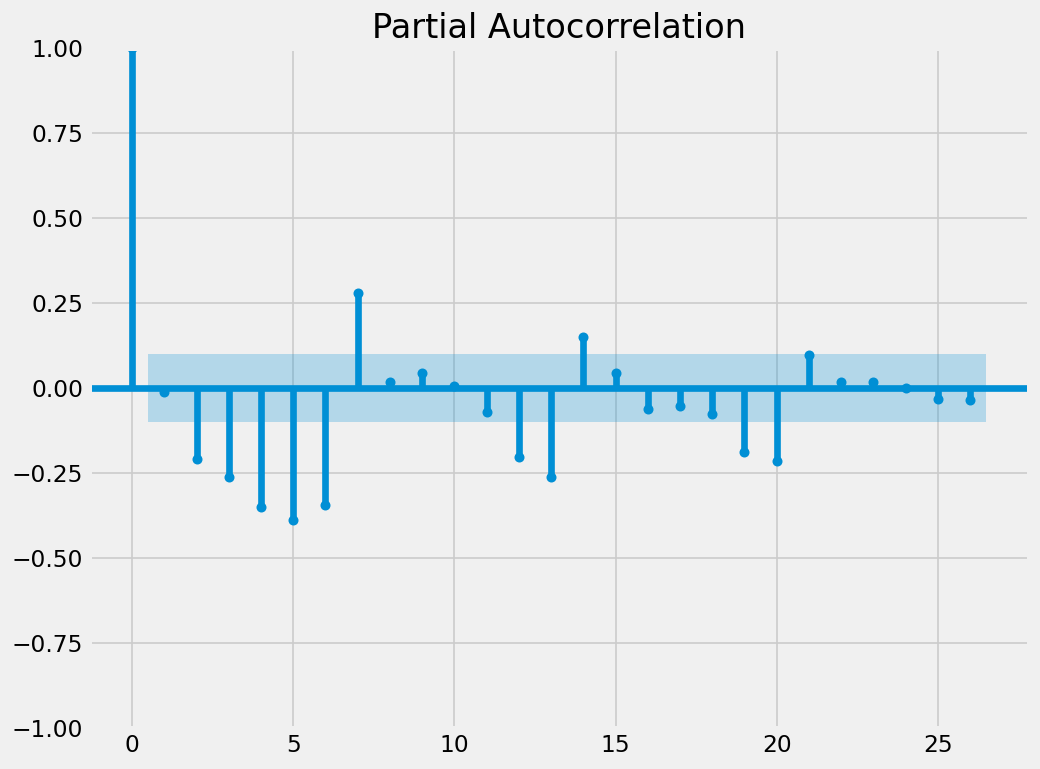

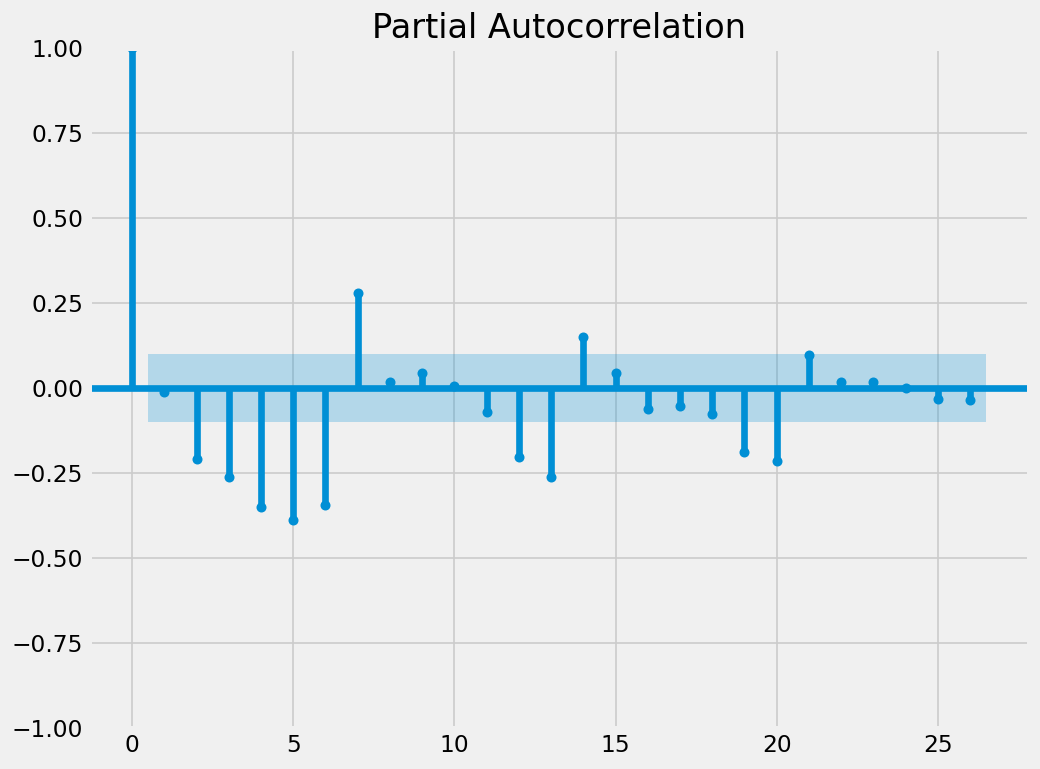

In [90]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data.Views.diff().dropna())

In [91]:
# Để tìm ra giá trị của q, chúng ta có thể sử dụng đồ thị ACF. 
# Điều này sẽ cho chúng ta biết cần có bao nhiêu đường trung bình động 
# để loại bỏ tự tương quan khỏi chuỗi thời gian cố định.

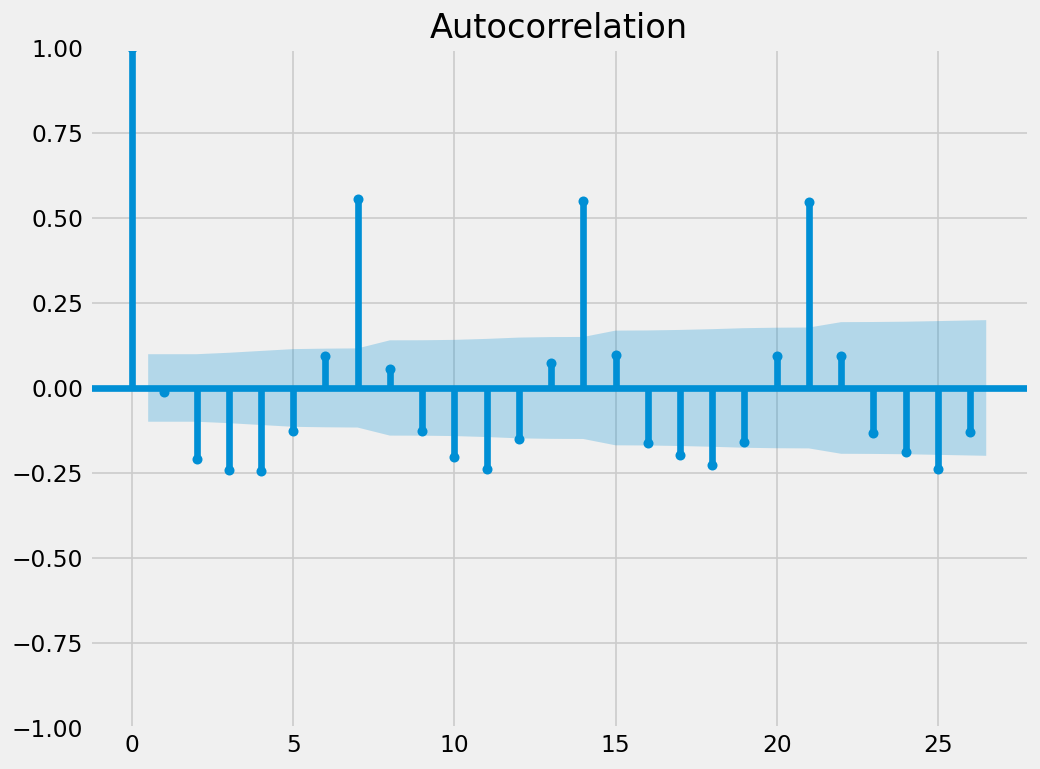

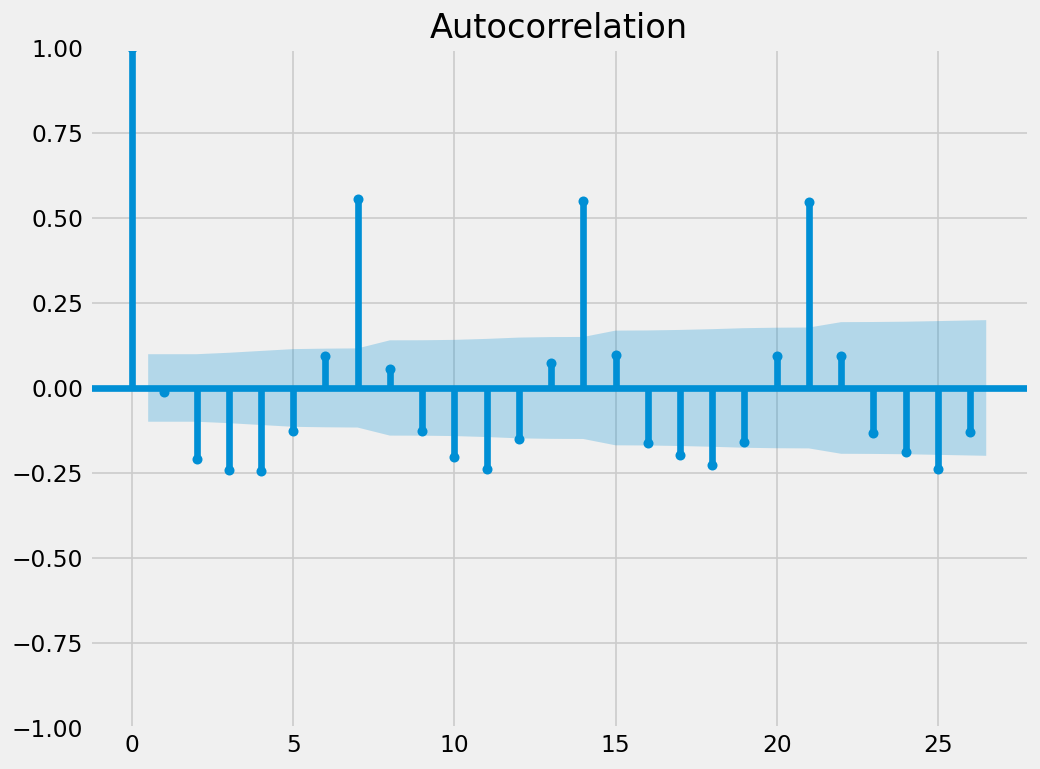

In [92]:
plot_acf(data.Views.diff().dropna())

In [96]:
# Đào tạo mô hình SARIMA cho nhiệm vụ dự báo lưu lượng truy cập trang web:
# p là chuỗi tự hồi qui AR (auto regression)
# q là chuỗi trung bình trượt MA (moving average)

p, d, q = 5, 1, 2
model=sm.tsa.statespace.SARIMAX(data['Views'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Views   No. Observations:                  391
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood               -3099.354
Date:                            Fri, 13 Jan 2023   AIC                           6228.707
Time:                                    16:40:00   BIC                           6287.731
Sample:                                         0   HQIC                          6252.133
                                            - 391                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7955      0.133      5.971      0.000       0.534       1.057
ar.L2         -0.7816      0.136   

In [94]:
#Dự báo lưu lượng truy cập trên trang web trong 50 ngày tới.
predictions = model.predict(len(data), len(data) + 50)
print(predictions)

391     9862.560866
392    10764.483641
393    10721.995890
394     9837.168835
395     8752.502809
396     8196.620187
397     8903.975064
398     9679.184815
399    10268.496275
400    10589.224994
401     9783.664314
402     9312.838776
403     9013.807059
404     9055.159019
405    10527.083770
406    10987.584813
407    10837.676321
408    10016.830359
409     9398.883637
410     8593.783610
411     9138.783965
412    10392.964980
413    10590.455491
414    10764.284693
415    10219.721562
416     9402.067711
417     9027.923795
418     9161.237159
419     9904.297014
420    10233.978265
421    10688.960822
422     9853.892705
423     9506.440507
424     9039.923187
425     8781.654393
426    10107.756215
427    10820.430295
428    10871.065000
429    10349.770775
430     9383.537246
431     8622.265320
432     8665.377159
433    10035.814138
434    10482.309070
435    10796.543501
436    10434.471486
437     9270.747219
438     9130.200194
439     9328.257865
440    10284.825672


<AxesSubplot:>

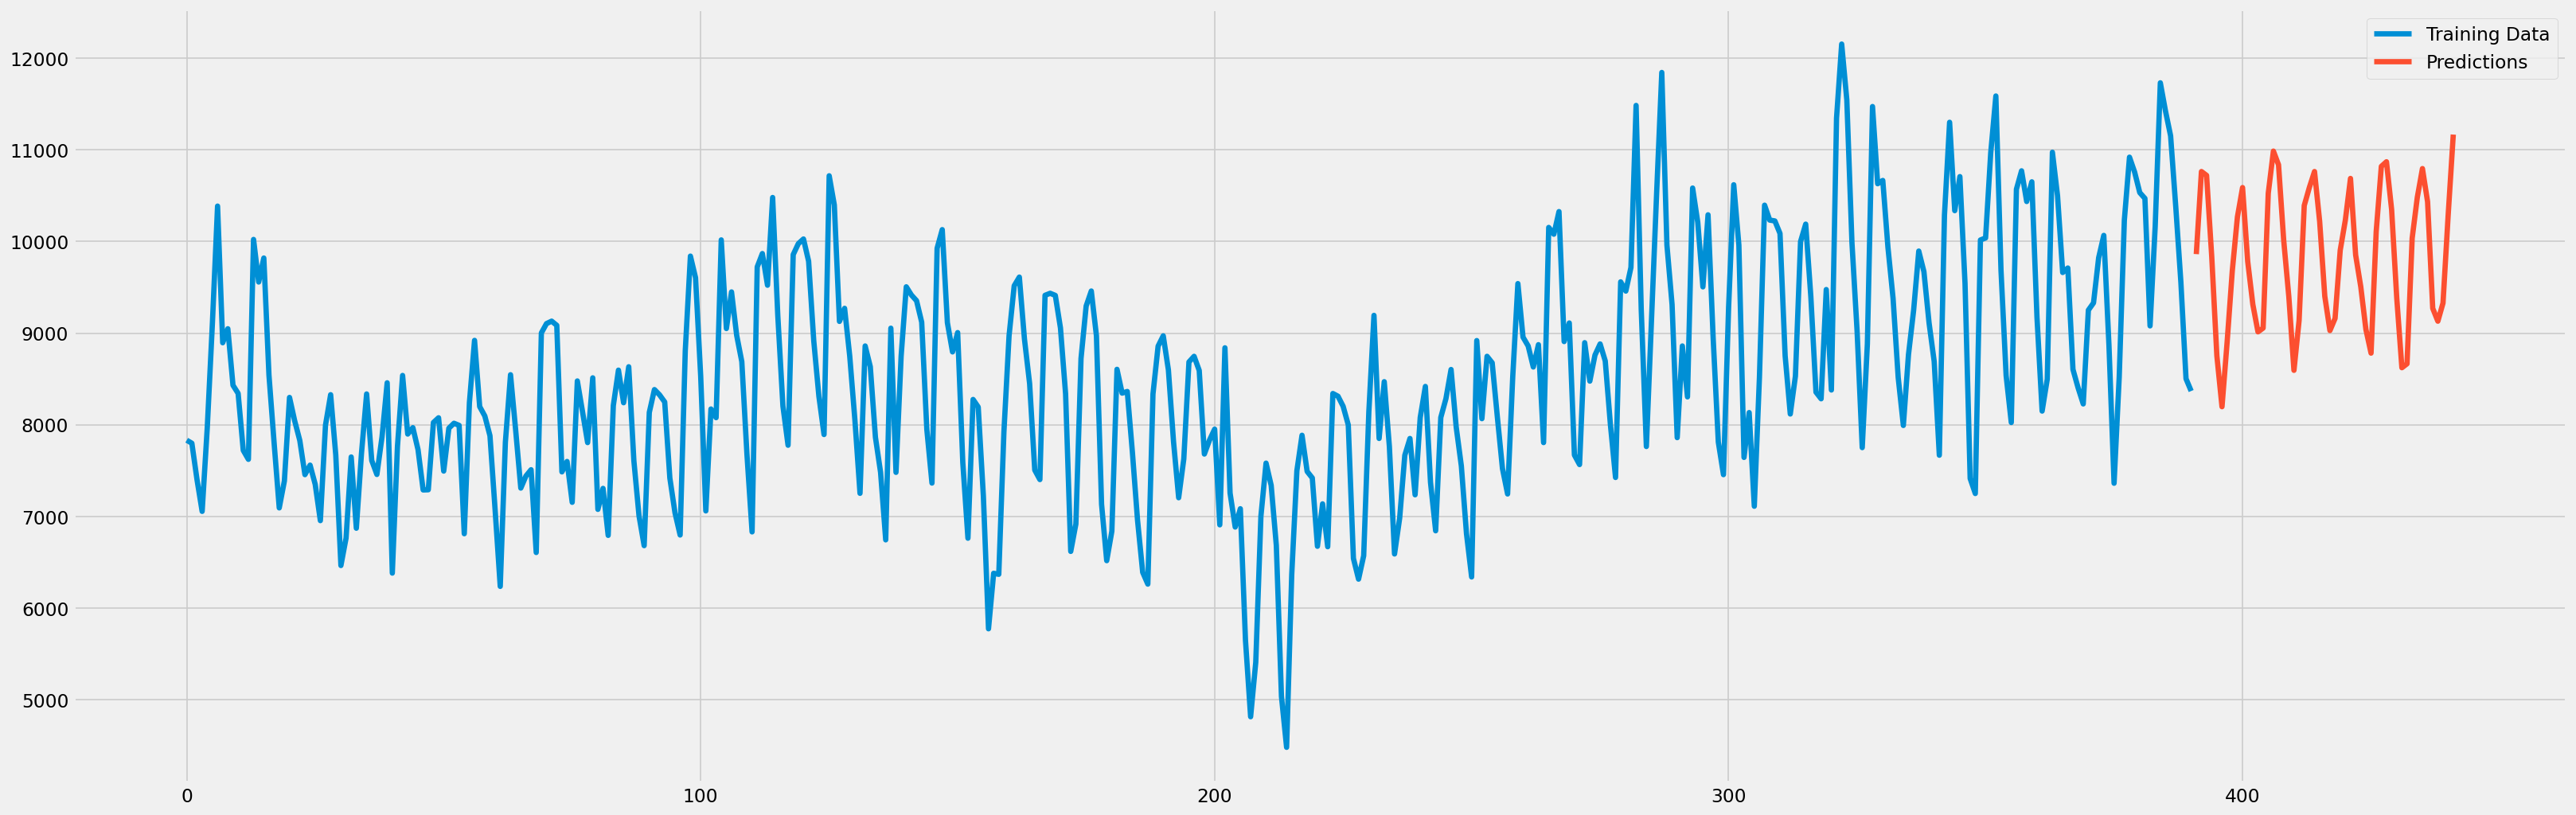

In [95]:
#Dữ liệu được dùng để training
data["Views"].plot(legend=True, label="Training Data", 
                   figsize=(30, 10))

#Xuất ra lưu lượng truy cập trên trang web trong 50 ngày tới
predictions.plot(legend=True, label="Predictions")